In [2]:
import os
from PIL import Image
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import random
import pickle
from tqdm import tqdm

## Read Dataset

1. Load from folder - run this if no .pickle file

In [3]:
def read_image(base_folder: str, image_size: tuple[int, int]) -> tuple[np.array, np.array]:
    X = []
    y = []
    for label in os.listdir(base_folder):
        label_folder = f"{base_folder}/{label}"
        print(f"Currently reading {label_folder}")
        for image_name in tqdm(os.listdir(label_folder)):
            if image_name.split('.')[-1] in ('jpg', 'png', 'gif'):
                image_path = f"{label_folder}/{image_name}"
                image = Image.open(image_path)
                image = image.convert('RGB')
                image = image.resize(image_size)
                X.append(image)
                y.append(label)
    X = np.array([np.array(x) for x in X])
    y = np.array(y)
    return (X, y)

In [4]:
X, y = read_image("Model Datasets", (128, 128))

Currently reading Model Datasets/A


100%|██████████| 200/200 [00:14<00:00, 13.69it/s]


Currently reading Model Datasets/C


100%|██████████| 200/200 [00:14<00:00, 14.09it/s]


Currently reading Model Datasets/E


100%|██████████| 200/200 [00:14<00:00, 13.46it/s]


### Visualize Data

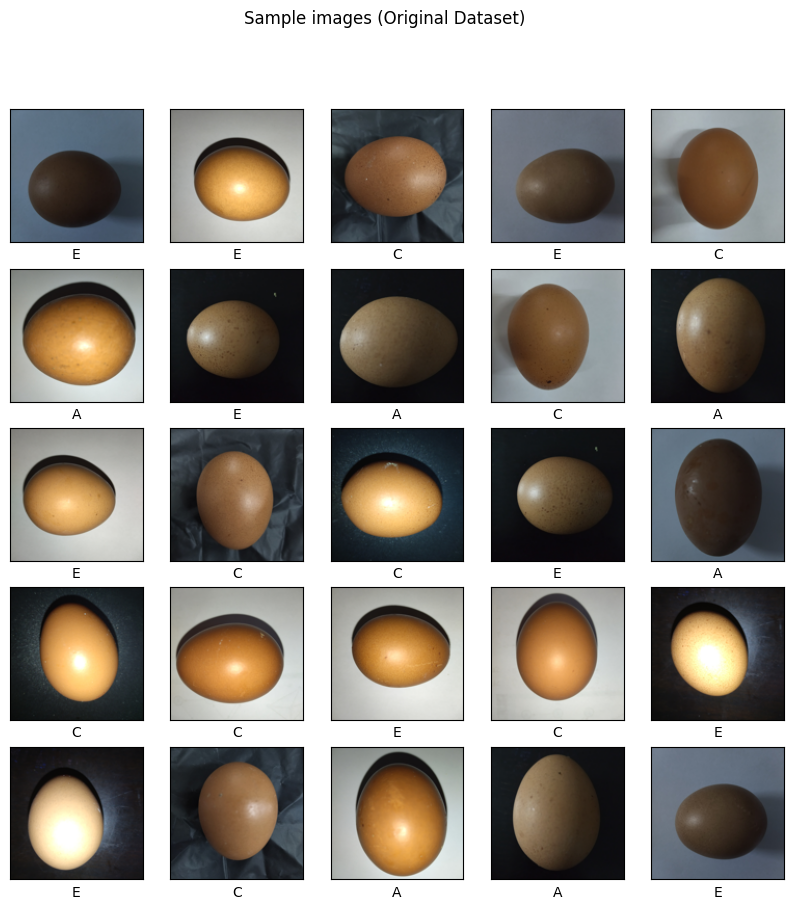

In [5]:

# Get the indices of 25 random images
random_indices = random.sample(range(len(X)), 25)

fig = plt.figure(figsize=(10, 10))
fig.suptitle('Sample images (Original Dataset)')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X[random_indices[i]])
    plt.xlabel(y[random_indices[i]])
plt.show()

## Preprocessing

1. Resize to 300 x 300 px
2. Negative Tranformation

In [6]:
print(len(X))

600


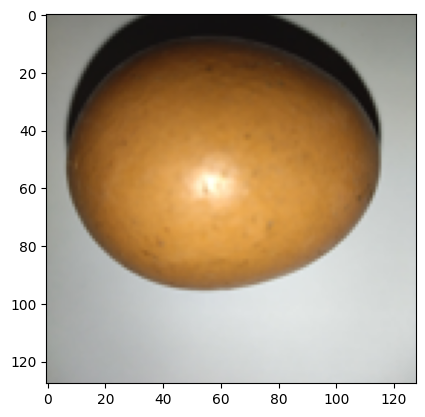

In [7]:
plt.imshow(X[0])

In [8]:
import cv2
# gray = (X_train_resized[0] * 255).astype(np.uint8)
# X_gray = [cv2.cvtColor(np.uint8(X_train_resized), cv2.COLOR_RGB2GRAY) for image in X_train_resized]
# plt.imshow(X_gray, cmap='gray')


# Assuming X_train_resized is a list of resized RGB images (NumPy arrays)
X_gray = [cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY) for image in X]

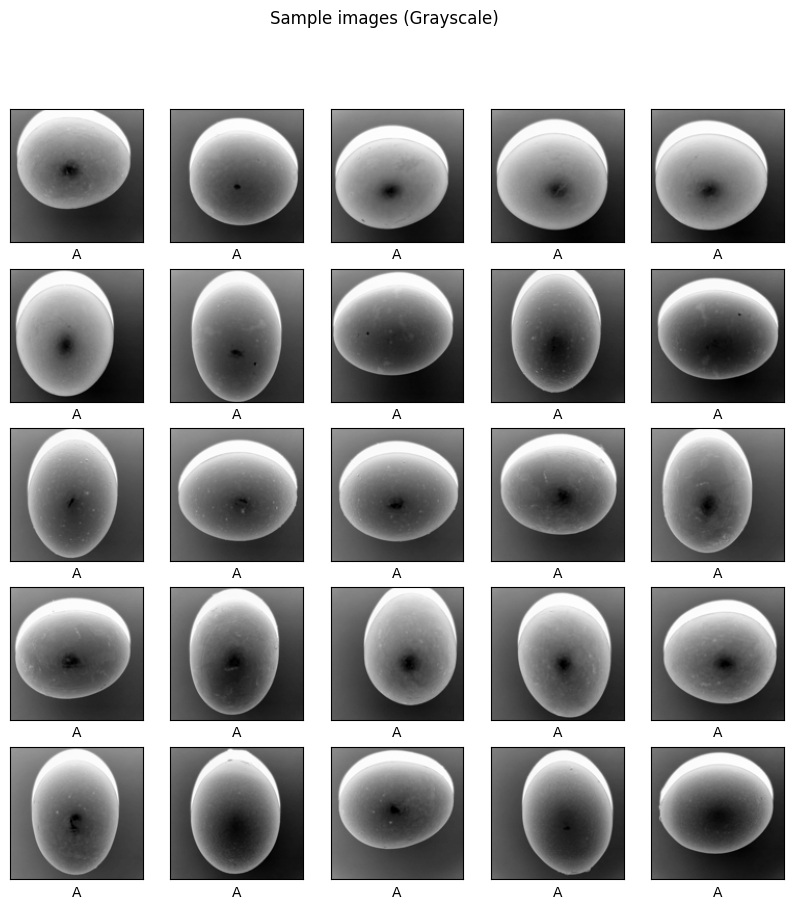

In [9]:
# Visualize the data
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Sample images (Grayscale)')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_gray[i], cmap='gray')
    plt.xlabel(y[i])
plt.show()

In [10]:
# Negative Transformation
# X_train_gray_negative = abs(255-X_train_gray)
# X_val_gray_negative = abs(255-X_val_gray)
# X_train_gray_negative = abs(255-X_test_gray)

X_gray_negative = [255 - img for img in X_gray]


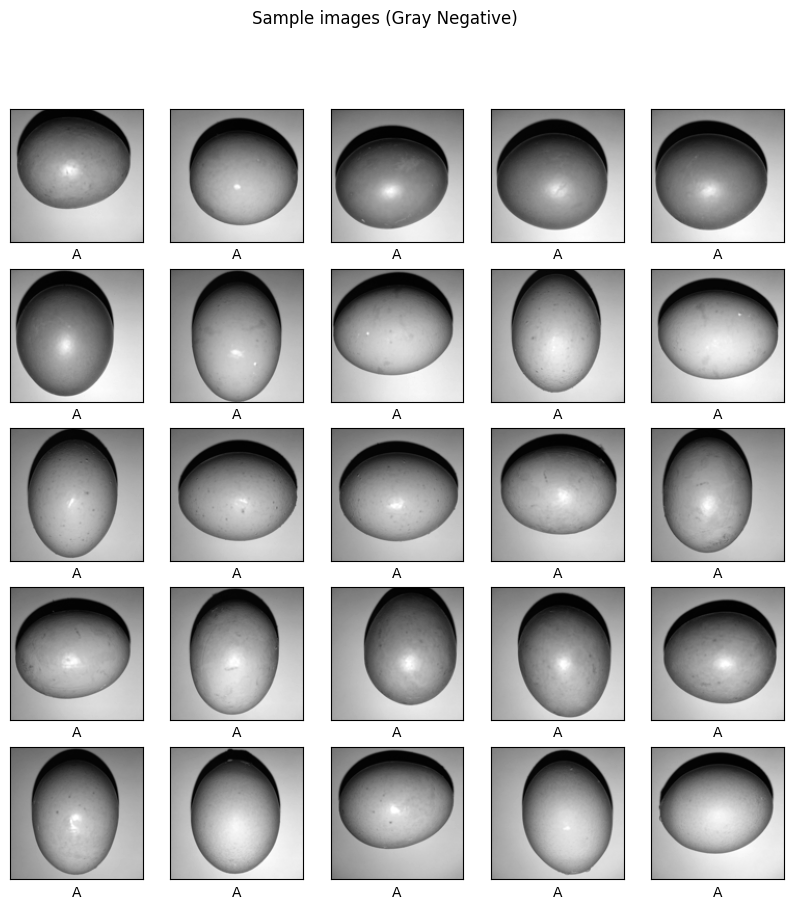

In [11]:
# Visualize the data
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Sample images (Gray Negative)')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_gray_negative[i], cmap='gray')
    plt.xlabel(y[i])
plt.show()

Comparison with Original

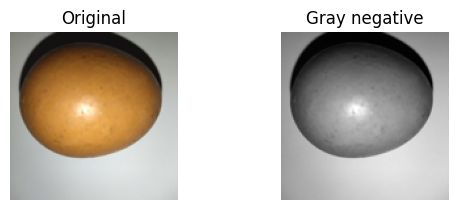

In [12]:
plt.subplot(2, 2, 1), plt.imshow(X[0]), plt.title("Original"), plt.axis("off")
plt.subplot(2, 2, 2), plt.imshow(X_gray_negative[0], cmap='gray'), plt.title("Gray negative"), plt.axis("off")

plt.show()

In [13]:
# Histogram Equalization
X_equalized = [cv2.equalizeHist(img) for img in X_gray_negative]

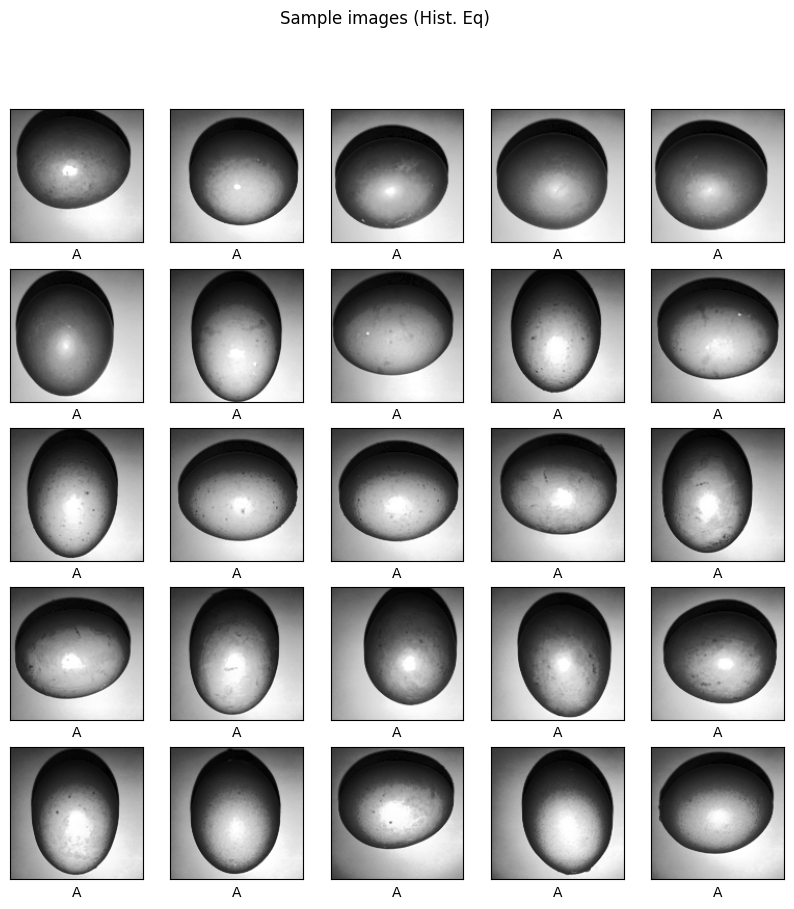

In [14]:
# Visualize the data
fig = plt.figure(figsize=(10, 10))
fig.suptitle('Sample images (Hist. Eq)')
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_equalized[i], cmap='gray')
    plt.xlabel(y[i])
plt.show()

In [15]:
X_equalized = np.array(X_equalized)

In [16]:
X_equalized.shape

(600, 128, 128)

## Model Training

In [17]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Assuming X_edges_rgb_stretched_rgb_sobel contains Sobel edge-detected images and y contains labels

# Reshape Sobel edge-detected images to a flat 1D array for each sample
X_flattened = X_equalized.reshape(X_equalized.shape[0], -1)

# Initialize StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=74)

# Lists to store results from each fold
accuracy_list = []
classification_reports = []

# Perform 10-fold cross-validation
for fold_num, (train_index, test_index) in enumerate(skf.split(X_flattened, y), start=1):
    X_train_fold, X_test_fold = X_flattened[train_index], X_flattened[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train the classifier on the training data
    rf_classifier.fit(X_train_fold, y_train_fold)

    # Predict on the test data
    y_pred_fold = rf_classifier.predict(X_test_fold)

    # Calculate accuracy for each fold
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_list.append(accuracy_fold)

    # Print the classification report for each fold
    classification_report_fold = classification_report(y_test_fold, y_pred_fold, digits=4)
    classification_reports.append(classification_report_fold)
    print(f"Fold {fold_num} - Classification Report:\n{classification_report_fold}\n")

# Calculate and print the mean accuracy
mean_accuracy = np.mean(accuracy_list)
print(f"Mean Accuracy Across Folds: {mean_accuracy:.4f}")

# Calculate and print the mean classification report
mean_classification_report = np.mean([np.array([float(x) for x in report.split()[-4:]]) for report in classification_reports], axis=0)
print("Mean Classification Report:")
print(f"Precision: {mean_classification_report[0]:.4f}")
print(f"Recall:    {mean_classification_report[1]:.4f}")
print(f"F1-Score:  {mean_classification_report[2]:.4f}")
print(f"Support:   {mean_classification_report[3]:.4f}")


Fold 1 - Classification Report:
              precision    recall  f1-score   support

           A     0.9500    0.9500    0.9500        20
           C     0.9500    0.9500    0.9500        20
           E     0.9500    0.9500    0.9500        20

    accuracy                         0.9500        60
   macro avg     0.9500    0.9500    0.9500        60
weighted avg     0.9500    0.9500    0.9500        60


Fold 2 - Classification Report:
              precision    recall  f1-score   support

           A     0.9091    1.0000    0.9524        20
           C     1.0000    0.9000    0.9474        20
           E     1.0000    1.0000    1.0000        20

    accuracy                         0.9667        60
   macro avg     0.9697    0.9667    0.9666        60
weighted avg     0.9697    0.9667    0.9666        60


Fold 3 - Classification Report:
              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000        20
           C     0.9524    1.00

In [18]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report

# Assuming X_edges_rgb_stretched_rgb_sobel contains Sobel edge-detected images and y contains labels

# Reshape Sobel edge-detected images to a flat 1D array for each sample
X_flattened = X_equalized.reshape(X_equalized.shape[0], -1)

# Initialize StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create a Random Forest classifier
svm_classifier = SVC(random_state=74)


# Lists to store results from each fold
accuracy_list = []
classification_reports = []

# Pesvmorm 10-fold cross-validation
for fold_num, (train_index, test_index) in enumerate(skf.split(X_flattened, y), start=1):
    X_train_fold, X_test_fold = X_flattened[train_index], X_flattened[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train the classifier on the training data
    svm_classifier.fit(X_train_fold, y_train_fold)

    # Predict on the test data
    y_pred_fold = svm_classifier.predict(X_test_fold)

    # Calculate accuracy for each fold
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_list.append(accuracy_fold)

    # Print the classification report for each fold
    classification_report_fold = classification_report(y_test_fold, y_pred_fold, digits=4)
    classification_reports.append(classification_report_fold)
    print(f"Fold {fold_num} - Classification Report:\n{classification_report_fold}\n")

# Calculate and print the mean accuracy
mean_accuracy = np.mean(accuracy_list)
print(f"Mean Accuracy Across Folds: {mean_accuracy:.4f}")

# Calculate and print the mean classification report
mean_classification_report = np.mean([np.array([float(x) for x in report.split()[-4:]]) for report in classification_reports], axis=0)
print("Mean Classification Report:")
print(f"Precision: {mean_classification_report[0]:.4f}")
print(f"Recall:    {mean_classification_report[1]:.4f}")
print(f"F1-Score:  {mean_classification_report[2]:.4f}")
print(f"Support:   {mean_classification_report[3]:.4f}")


Fold 1 - Classification Report:
              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000        20
           C     1.0000    1.0000    1.0000        20
           E     1.0000    1.0000    1.0000        20

    accuracy                         1.0000        60
   macro avg     1.0000    1.0000    1.0000        60
weighted avg     1.0000    1.0000    1.0000        60


Fold 2 - Classification Report:
              precision    recall  f1-score   support

           A     0.9091    1.0000    0.9524        20
           C     0.9000    0.9000    0.9000        20
           E     0.9444    0.8500    0.8947        20

    accuracy                         0.9167        60
   macro avg     0.9178    0.9167    0.9157        60
weighted avg     0.9178    0.9167    0.9157        60


Fold 3 - Classification Report:
              precision    recall  f1-score   support

           A     1.0000    1.0000    1.0000        20
           C     1.0000    1.00

In [19]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import numpy as np


# Assuming X_edges_rgb_stretched_rgb_sobel contains Sobel edge-detected images and y contains labels

# Convert string labels to numeric labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Reshape Sobel edge-detected images to a flat 1D array for each sample
X_flattened = X_equalized.reshape(X_equalized.shape[0], -1)

# Initialize StratifiedKFold with 10 folds
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Create a Random Forest classifier
xgb_classifier = XGBClassifier()


# Lists to store results from each fold
accuracy_list = []
classification_reports = []

# Pexgborm 10-fold cross-validation
for fold_num, (train_index, test_index) in enumerate(skf.split(X_flattened, y), start=1):
    X_train_fold, X_test_fold = X_flattened[train_index], X_flattened[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Train the classifier on the training data
    xgb_classifier.fit(X_train_fold, y_train_fold)

    # Predict on the test data
    y_pred_fold = xgb_classifier.predict(X_test_fold)

    # Calculate accuracy for each fold
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracy_list.append(accuracy_fold)

    # Print the classification report for each fold
    classification_report_fold = classification_report(y_test_fold, y_pred_fold, digits=4)
    classification_reports.append(classification_report_fold)
    print(f"Fold {fold_num} - Classification Report:\n{classification_report_fold}\n")

# Calculate and print the mean accuracy
mean_accuracy = np.mean(accuracy_list)
print(f"Mean Accuracy Across Folds: {mean_accuracy:.4f}")

# Calculate and print the mean classification report
mean_classification_report = np.mean([np.array([float(x) for x in report.split()[-4:]]) for report in classification_reports], axis=0)
print("Mean Classification Report:")
print(f"Precision: {mean_classification_report[0]:.4f}")
print(f"Recall:    {mean_classification_report[1]:.4f}")
print(f"F1-Score:  {mean_classification_report[2]:.4f}")
print(f"Support:   {mean_classification_report[3]:.4f}")


Fold 1 - Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     0.9524    1.0000    0.9756        20
           2     1.0000    0.9500    0.9744        20

    accuracy                         0.9833        60
   macro avg     0.9841    0.9833    0.9833        60
weighted avg     0.9841    0.9833    0.9833        60


Fold 2 - Classification Report:
              precision    recall  f1-score   support

           0     0.9091    1.0000    0.9524        20
           1     1.0000    0.8500    0.9189        20
           2     0.9524    1.0000    0.9756        20

    accuracy                         0.9500        60
   macro avg     0.9538    0.9500    0.9490        60
weighted avg     0.9538    0.9500    0.9490        60


Fold 3 - Classification Report:
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        20
           1     0.9524    1.00